In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, PowerTransformer

In [2]:
data = pd.read_csv('dataset.csv')
data.drop(columns='id', inplace=True)

In [3]:
data.head()

,water,uv,area,fertilizer_usage,yield,pesticides,region,categories
0,5.615,65.281,3.230,0,7.977,8.969,0,"b,a,c"
1,7.044,73.319,9.081,0,23.009,7.197,0,"c,a,d"
2,5.607,60.038,2.864,2,23.019,7.424,0,"d,a"
3,9.346,64.719,2.797,2,28.066,1.256,0,d
4,7.969,NaN,5.407,1,29.140,0.274,0,"c,d"


In [4]:
data.isnull().mean()

water               0.042
uv                  0.051
area                0.000
fertilizer_usage    0.000
yield               0.000
pesticides          0.000
region              0.000
categories          0.000
dtype: float64

# Introduction
After conducting some research in terms of usefulness of the application my best guess that the predicted variable here has to be `yield`. Predicting such variable might provide farmers some insight in terms of what they can expect when applying different watering or pesticides on a given area. Those aspects will be analysed further below

In [5]:
target_col = 'yield'
train_x, test_x, train_y, test_y = train_test_split(data.drop(columns=target_col), data[target_col])

In [6]:
train_x.head()

,water,uv,area,fertilizer_usage,pesticides,region,categories
622,10.414,63.536,6.836,2,3.339,3,d
282,4.418,86.677,7.951,2,0.368,2,"b,c"
506,11.667,63.520,9.622,4,2.340,2,"a,b,c"
600,5.344,85.826,13.743,1,1.315,3,c
582,10.027,53.440,7.170,3,0.879,3,"d,b,c"


In [7]:
train_x.isnull().mean()*100

water               3.466667
uv                  4.933333
area                0.000000
fertilizer_usage    0.000000
pesticides          0.000000
region              0.000000
categories          0.000000
dtype: float64

As we wee here, there is some values missing in two columns water and uv.
First, let's investigate the distribution of those variables and see if the existing data reseamble normal or skewed distribution. Then, we need to investigate the outliers

In [8]:
def plot_variable_diagnosis(dataset, col_name):
    """Plot the diagnostics for a given column name
    
    Create 3 charts; distribution, Q-Q plot and boxplot
    to investigate the nature of the variables.
    
    :param dataset: input dataset:
    :type dataset: pd.DataFrame
    :param col_name: name of the variable to investigate
    :type col_name: str
    """
    
    plt.figure(figsize=(16, 4))
        
    plt.subplot(1, 3, 1)
    sns.distplot(dataset[col_name], hist=True, bins=30)
    plt.title('Distribution')
    
    plt.subplot(1, 3, 2)
    stats.probplot(dataset[col_name], dist='norm', plot=plt)
    plt.ylabel('RM quantiles')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(dataset[col_name])
    plt.title('Box plot')
    
    plt.show()

## Water variable analysis and imputation

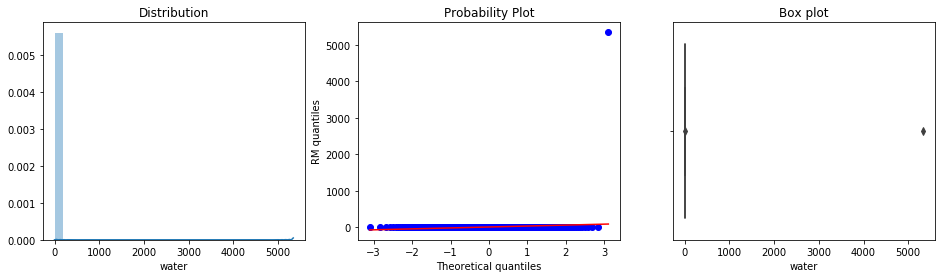

In [9]:
plot_variable_diagnosis(train_x[~train_x.water.isnull()], 'water')

The data is not only missing but it also its distribution is a bit skewed due to outliers. First, we will compute the lower and upper bounds for using interquantile range and visualize the distribution of data that is between our boundaries.

In [10]:
def find_skewed_boundaries(dataset, col_name, distance):
    """Find lower and upper bounds for the distributed data
    
    A normally distributed variable have mean and median approximaly equal.
    In case the distribution is skewed, mean is affected by some variables in the tail
    and therefore shifted in that direction. 
    
    """
    
    inter_quantile_range = dataset[col_name].quantile(0.75) - dataset[col_name].quantile(0.25)
    lower_bound = dataset[col_name].quantile(0.25) - (inter_quantile_range * distance)
    upper_bound = dataset[col_name].quantile(0.75) + (inter_quantile_range * distance)
    
    return lower_bound, upper_bound

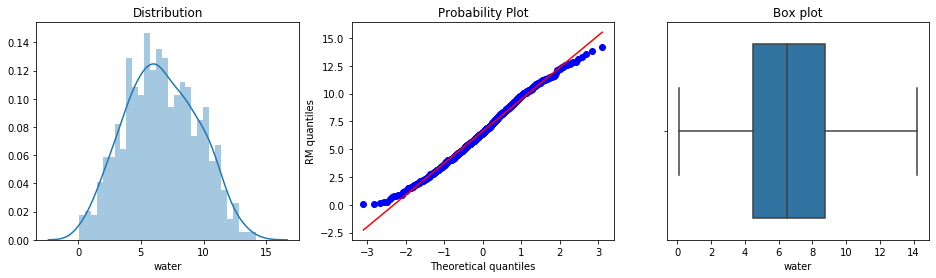

In [11]:
lower_bound, upper_bound = find_skewed_boundaries(train_x, 'water', 1.5)
plot_variable_diagnosis(train_x[(train_x.water > lower_bound) & (train_x.water < upper_bound)], 'water')

In [12]:
print(
    'Lower and upper bounds are {:.2f} and {:.2f}, respectively'.format(lower_bound, upper_bound)
)
print('Number of samples where water has negative value: {}'.format(train_x[train_x.water < 0].shape[0]))

Lower and upper bounds are -1.86 and 15.13, respectively
Number of samples where water has negative value: 0


In [13]:
water_mean = train_x[(train_x.water > lower_bound) & (train_x.water < upper_bound)].water.mean()
water_median = train_x[(train_x.water > lower_bound) & (train_x.water < upper_bound)].water.median()
print(
    'Water variable mean: {0:.2f} and median: {1:.2f}'.format(water_mean, water_median)
)

Water variable mean: 6.63 and median: 6.48


Here we notice that the distribution of the data is close to normal but slightly skewed. We decide then to impute the missing values using median and cap the outliers with the upper bount (no negative outliers).

In [14]:
train_x.loc[train_x.water > upper_bound, 'water'] = upper_bound
train_x.loc[train_x.water.isnull(), 'water'] = water_median

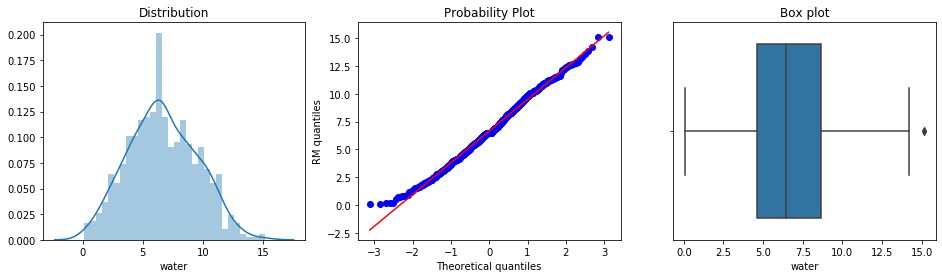

In [15]:
plot_variable_diagnosis(train_x, 'water')

mean/median imputation distorts the original variance and original variable distribution. We notice a big jump in the distribution since the missing values were willed with median. We also notice a value that potentially might me an outlier yet that refers to the previous statement that the new distribution is slightly distorted.

## UV variable analysis and imputation

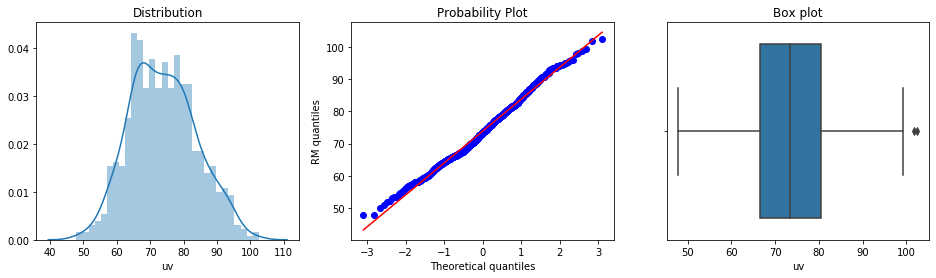

In [16]:
plot_variable_diagnosis(train_x[~train_x.uv.isnull()], 'uv')

Here, we will apply exactly the same approach as previously, to impute the missing values and cap the outliers using lower and upper bounds

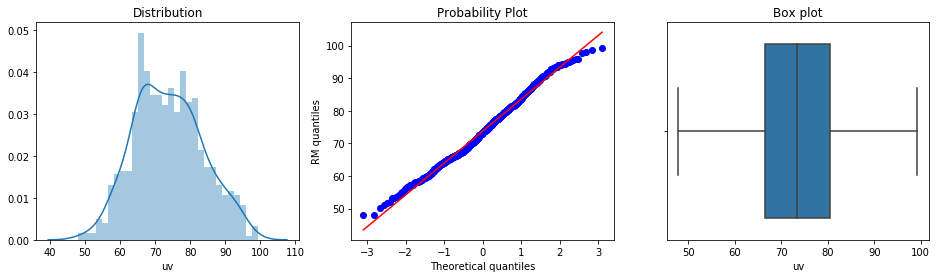

In [17]:
lower_bound_uv, upper_bound_uv = find_skewed_boundaries(train_x, 'uv', 1.5)
plot_variable_diagnosis(train_x[(train_x.uv > lower_bound_uv) & (train_x.uv < upper_bound_uv)], 'uv')

In [18]:
uv_mean = train_x[(train_x.uv > lower_bound_uv) & (train_x.uv < upper_bound_uv)].uv.mean()
uv_median = train_x[(train_x.uv > lower_bound_uv) & (train_x.uv < upper_bound_uv)].uv.median()
print(
    'UV variable mean: {0:.2f} and median: {1:.2f}'.format(uv_mean, uv_median)
)

UV variable mean: 73.78 and median: 73.47


In [19]:
train_x.loc[train_x.uv > upper_bound_uv, 'uv'] = upper_bound_uv
train_x.loc[train_x.uv < lower_bound_uv, 'uv'] = lower_bound_uv
train_x.loc[train_x.uv.isnull(), 'uv'] = uv_median

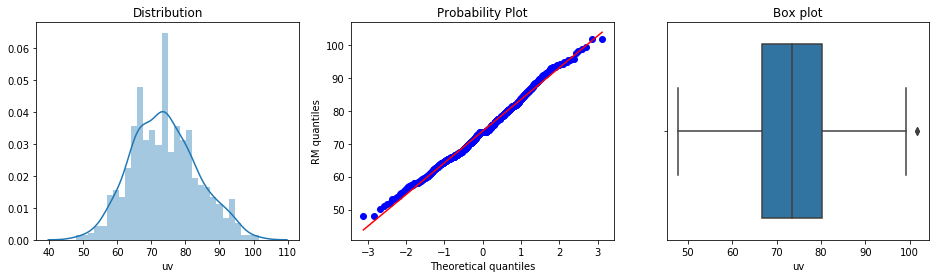

In [20]:
plot_variable_diagnosis(train_x, 'uv')

## Area variable analysis

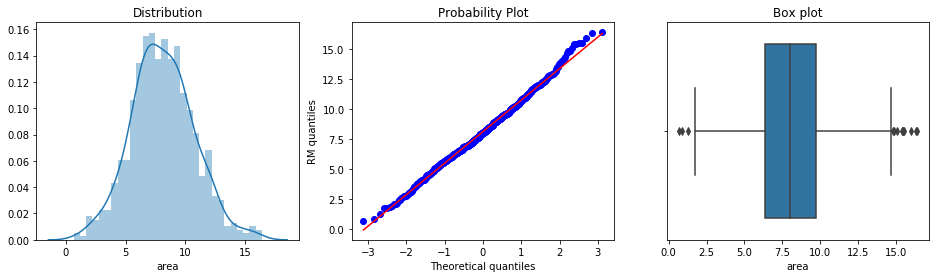

In [21]:
plot_variable_diagnosis(train_x, 'area')

Here, the number of outliers seems to be a bit larger than in previous cases. We 

In [22]:
lower_bound_area, upper_bound_area = find_skewed_boundaries(train_x, 'area', 1.5)
nr_area_outliers = train_x[(train_x.area < lower_bound_area) | (train_x.area > upper_bound_area)].shape[0]
print(
    'number of `area` samples classified as outliers is {} which stands for {:.2f}% of the whole training set'.format(
        nr_area_outliers, nr_area_outliers*100/train_x.shape[0]
    )
)

number of `area` samples classified as outliers is 13 which stands for 1.73% of the whole training set


The number of outliers stand for roughly 2% of data therefore we will cap it and investigate the distribution again

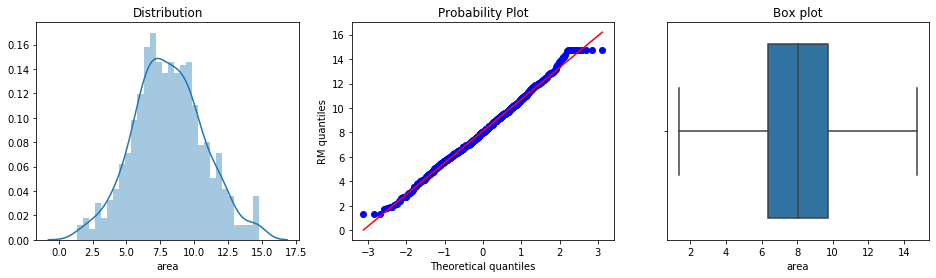

In [23]:
train_x.loc[train_x.area > upper_bound_area, 'area'] = upper_bound_area
train_x.loc[train_x.area < lower_bound_area, 'area'] = lower_bound_area
plot_variable_diagnosis(train_x, 'area')

## Pesticides variable analysis and imputation

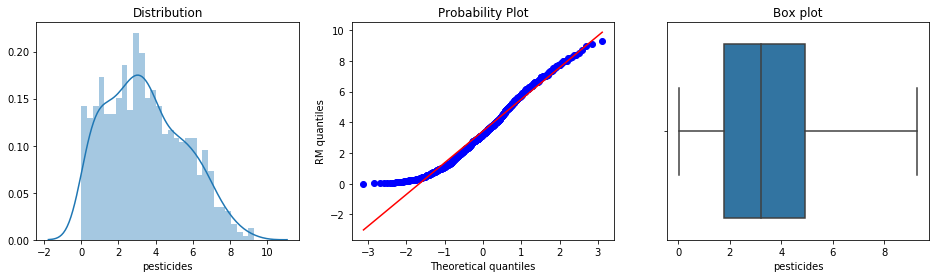

In [24]:
plot_variable_diagnosis(train_x, 'pesticides')

In [25]:
train_x.pesticides.min()

0.013999999999999999

Here the distribution is obviously skewed so we use different transformations in order to make it more gaussian-like

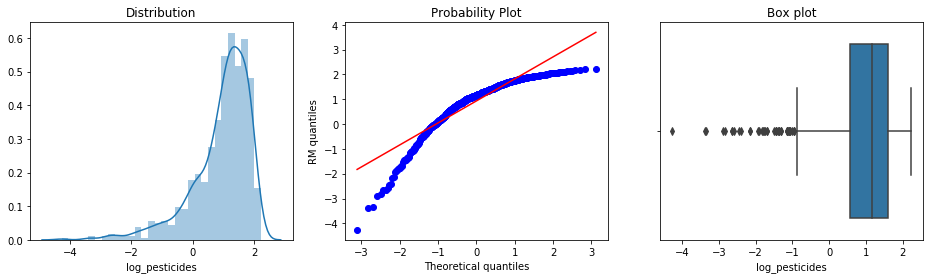

In [26]:
train_x['log_pesticides'] = np.log(train_x.pesticides)
plot_variable_diagnosis(train_x, 'log_pesticides')

In [27]:
train_x.drop(columns='log_pesticides', inplace=True)

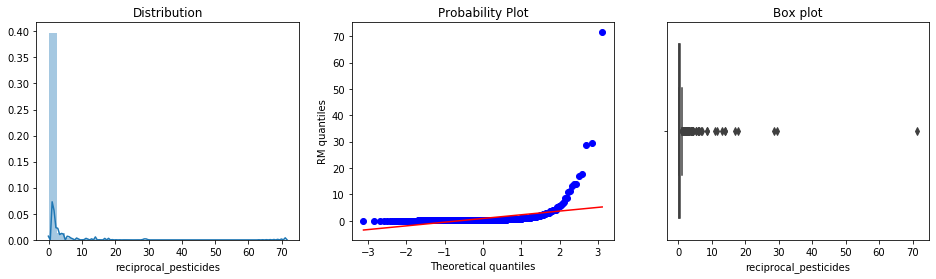

In [28]:
train_x['reciprocal_pesticides'] = 1 / train_x.pesticides
plot_variable_diagnosis(train_x, 'reciprocal_pesticides')

In [29]:
train_x.drop(columns='reciprocal_pesticides', inplace=True)

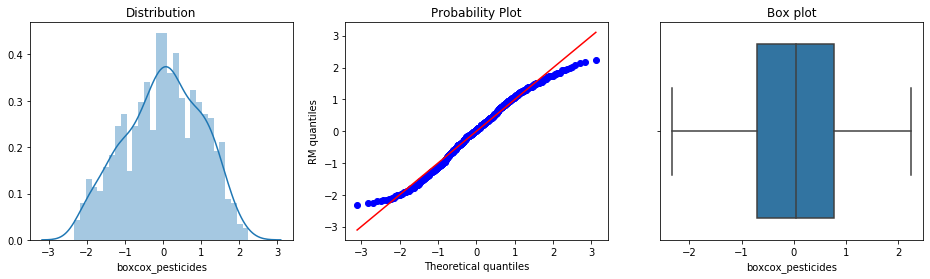

In [30]:
pesticides_transformer = PowerTransformer(method='box-cox')
train_x['boxcox_pesticides'] = pesticides_transformer.fit_transform(train_x.pesticides.values.reshape(-1, 1))
plot_variable_diagnosis(train_x, 'boxcox_pesticides')

Using box-cox transformation allowed us to obtain the distribution of pesticides variable which is much closer to normal than before. Therefore, we keep this transformation.

In [31]:
train_x.drop(columns='pesticides', inplace=True)

In [37]:
train_x.rename(columns={'boxcox_pesticides': 'pesticides'}, inplace=True)

In [32]:
print('Unique region values: {}'.format(train_x.region.unique()))
print('Unique fertilizer_usage values: {}'.format(train_x.fertilizer_usage.unique()))

Unique region values: [3 2 6 1 5 4 0]
Unique fertilizer_usage values: [2 4 1 3 0 5]


We notice that region and fertilizer_usage contain numerical, ordered values. As much as it makes sense for the fertilizer usage,
region values could be encoded so that they do not make ordered sense. Let's focus on the categories variable as this column contains a list of different values which can be encoded using a multilabel binarizer.

In [38]:
train_x.dtypes

water               float64
uv                  float64
area                float64
fertilizer_usage      int64
region                int64
categories           object
pesticides          float64
dtype: object

In [39]:
train_x.categories.unique()

array(['d', 'b,c', 'a,b,c', 'c', 'd,b,c', 'd,c', 'd,b', 'b,c,a,d', 'a,c',
       'b,d,a', 'b', 'c,b,d', 'a,b', 'a,c,b', 'd,a,c,b', 'b,d,a,c',
       'c,b,d,a', 'c,a,b,d', 'a,d,b,c', 'd,a,b', 'c,b', 'c,a,d,b',
       'd,c,b', 'b,c,a', 'c,a', 'd,a,c', 'a', 'b,d,c', 'c,b,a', 'd,b,c,a',
       'b,d,c,a', 'c,d,b', 'c,a,b', 'b,d', 'd,b,a,c', 'c,b,a,d', 'b,c,d',
       'a,d', 'b,a,c', 'c,d', 'd,b,a', 'a,c,b,d', 'a,c,d', 'd,a',
       'b,c,d,a', 'b,a', 'b,a,d,c', 'c,d,a', 'd,c,a', 'b,a,d', 'a,d,c,b',
       'c,a,d', 'b,a,c,d', 'c,d,a,b', 'd,c,b,a', 'a,d,b', 'd,a,b,c',
       'a,b,c,d', 'a,b,d', 'c,d,b,a'], dtype=object)

We see that this column contains strings with comma separated categories. First, we have to change them into 
lists of categories and then use the multilabel binarizer

In [40]:
train_x['categories'] = train_x.categories.apply(lambda x: x.split(','))

In [41]:
train_x.head()

,water,uv,area,fertilizer_usage,region,categories,pesticides
622,10.414,63.536,6.836,2,3,[d],0.095340
282,4.418,86.677,7.951,2,2,"[b, c]",-1.754669
506,11.667,63.520,9.622,4,2,"[a, b, c]",-0.390044
600,5.344,85.826,13.743,1,3,[c],-0.985988
582,10.027,53.440,7.170,3,3,"[d, b, c]",-1.295237


In [43]:
multi_label_binarizer = MultiLabelBinarizer()
transformed_train_data_categories = pd.DataFrame(
    multi_label_binarizer.fit_transform(train_x.categories),
    columns=multi_label_binarizer.classes_,
    index=train_x.index
)

In [44]:
multi_label_binarizer.classes_

array(['a', 'b', 'c', 'd'], dtype=object)

In [45]:
train_x = train_x.join(transformed_train_data_categories)

In [46]:
train_x.drop(columns='categories', inplace=True)

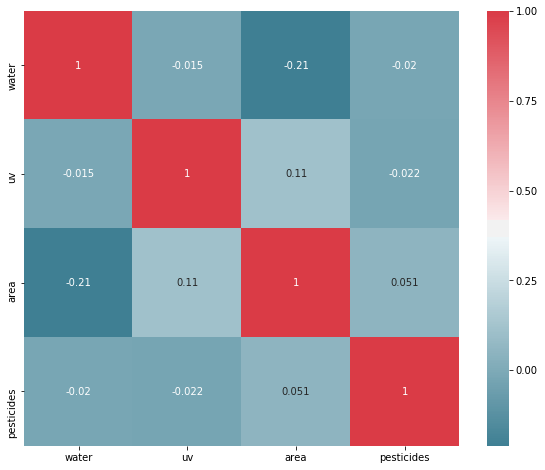

In [48]:
f, ax = plt.subplots(figsize=(10, 8))
corr = train_x[['water', 'uv', 'area', 'pesticides']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

We notice that some numerical features are slightly correlated but we decided to keep all the features at this step.

In [49]:
train_x.head()

,water,uv,area,fertilizer_usage,region,pesticides,a,b,c,d
622,10.414,63.536,6.836,2,3,0.095340,0,0,0,1
282,4.418,86.677,7.951,2,2,-1.754669,0,1,1,0
506,11.667,63.520,9.622,4,2,-0.390044,1,1,1,0
600,5.344,85.826,13.743,1,3,-0.985988,0,0,1,0
582,10.027,53.440,7.170,3,3,-1.295237,0,1,1,1


## Feature selection

Knowing that we have only 10 features, we will conduct the exhaustive feature selection which selects the best set of features provide the highest score for the given training set. As a model, we decide to take Gradient Boosting Regressor from the sklearn package.

In [51]:
feature_selector = ExhaustiveFeatureSelector(
    GradientBoostingRegressor(),
    min_features=1,
    max_features=len(train_x.columns),
    scoring='r2',
    print_progress=True,
    cv=3
)
feature_selector = feature_selector.fit(train_x.values, train_y)

Features: 1023/1023

In [52]:
feature_selector.best_idx_

(0, 2, 3, 4, 5, 7, 8)

In [60]:
best_features = train_x.columns[list(feature_selector.best_idx_)]
best_features

Index(['water', 'area', 'fertilizer_usage', 'region', 'pesticides', 'b', 'c'], dtype='object')

## Model training

We train our model skipping the part of parameters selection. This step could be conducted later in order to find the best set of parameters providing the highest results.

In [61]:
model = GradientBoostingRegressor()
model.fit(train_x[best_features], train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Model testing

Before we evaluate the performance of our model on the test set, we need to investigate the potentially missing variables and impute them if needed, using values computed on the training set. Then, we have to transform the pesticides column using the fitted transformer and finally handle different categories in the categories variable.

In [63]:
test_x.isnull().mean()

water               0.064
uv                  0.056
area                0.000
fertilizer_usage    0.000
pesticides          0.000
region              0.000
categories          0.000
dtype: float64

In [72]:
test_x.head()

,water,uv,area,fertilizer_usage,pesticides,region,categories
422,8.936,88.831,7.833,1,1.362177,2,a
934,4.395,73.470,12.640,0,0.493363,6,"d,c,b"
288,3.670,68.932,5.721,1,0.725304,2,c
836,6.509,87.019,8.775,1,1.331880,6,a
135,5.091,71.869,7.333,3,1.404740,1,"c,a,d"


In [64]:
test_x.loc[test_x.water.isnull(), 'water'] = water_median
test_x.loc[test_x.uv.isnull(), 'uv'] = uv_median

In [70]:
test_x['pesticides'] = pesticides_transformer.transform(test_x.pesticides.values.reshape(-1, 1))

In [73]:
test_x['categories'] = test_x.categories.apply(lambda x: x.split(','))
transformed_test_data_categories = pd.DataFrame(
    multi_label_binarizer.transform(test_x.categories),
    columns=multi_label_binarizer.classes_,
    index=test_x.index
)
test_x = test_x.join(transformed_test_data_categories)

In [75]:
test_x.drop(columns='categories', inplace=True)

In [76]:
test_x.head()

,water,uv,area,fertilizer_usage,pesticides,region,a,b,c,d
422,8.936,88.831,7.833,1,1.362177,2,1,0,0,0
934,4.395,73.470,12.640,0,0.493363,6,0,1,1,1
288,3.670,68.932,5.721,1,0.725304,2,0,0,1,0
836,6.509,87.019,8.775,1,1.331880,6,1,0,0,0
135,5.091,71.869,7.333,3,1.404740,1,1,0,1,1


In [78]:
predicted_y = model.predict(test_x[best_features])

In [86]:
model_score = model.score(test_x[best_features], test_y)

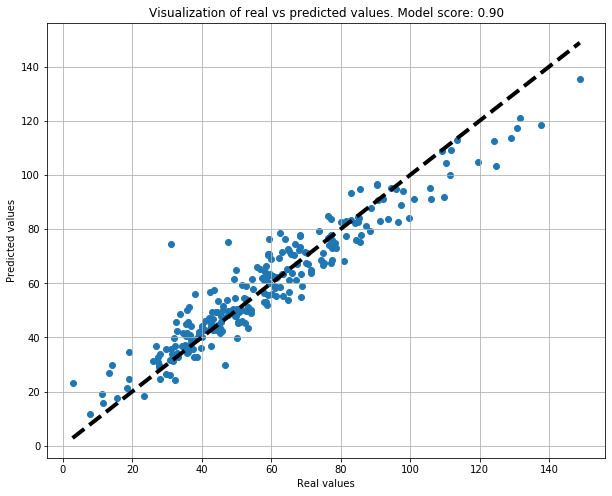

In [87]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(test_y, predicted_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Real values')
ax.set_ylabel('Predicted values')
plt.grid()
plt.title('Visualization of real vs predicted values. Model score: {:.2f}'.format(model_score))
plt.show()

The above chart shows that our model performs really well on the unseen data. The r-squared score reached 0.9 meaning that approximately 90% of the observed variation can be explained by the model's inputs. Here, we could also point out further steps for both data preprocessing and model improvement:
1. Find different encoding for region as the ordered numbers might affect the prediction.
2. Train different models with all possible sets of parameters (eg. using gridsearch).
3. Try combining models by applying stacking in order to predict the final score.
4. Get some expertise in the problem and try identifying other features which might be used in the problem.
If this model is supposed to serve farmers to identify podential yield, an API or another aplication should be built on topits final version should 